# 1. A small introduction

## What are Convolutional Neural Networks (CNN)

> Is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. <br>
>
> _[A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way, by Sumit Saha](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)_

## Example of CNN architecture

![CNN_schematic](https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

The design of CNN allows to apply similar concepts to Neural Networks with special data processing techniques on data and between layers to learn from image data. 

## Components

**Convolutional Layers**

The convultion in CNNs is a technique inspired by the organization of the visual cortex, as neurons respond to stimulius in a given field of view. The convolution is a way to propogate information from nearby pixels in an image. 

The aim of CNN is to **reduce the dimensions** and **keep the importan features** that help in good predictions.  

Essentially a convolution is a matrix multiplication between the image and a *kernel* (another matrix, smaller than the image). Note, the shape of your input data has changed after going through the convolution (_'valid padding'_, in contrast to _'same padding'_ where the original dimensions are kept)

<div style="text-align: center;">
<img src="images/kernel_snapshot.png"> </img>
    </div>

![convolution](https://miro.medium.com/max/1052/1*GcI7G-JLAQiEoCON7xFbhg.gif)
<div style="text-align: center;">
Convoluting a 5x5x1 image with a 3x3x1 kernel to get a 3x3x1 convolved feature. The kernel (shown in yellow) takes into account only the pixels in the two diagonals (marked as 'x1' in the lower right corner of the yellow matrix). Therefore, in the first (frozen) image there are 9 pixels with the kernel considering 5 of them with values : 1+1+0+1+1 = 4 (the value trasnfered to the convoled feature).
</div>

The kernel is not necessary to move one pixel at a time. By chaning the _stride_ we can select any kind of movement, which includes both the width and the height. A (1,1) stride will move one pixel right (stating always from the top left corner) and after completing the row it will move one pixel down (and left again). A (2,2 will do the similar thing but with two pixels moves. Hoever, in this case we also **downsampling** the extracted feature. 

**Activaltion function**

The function used to impose a non-linear transformation to the input data. Perhaps the most typical one used is the ReLU (Rectified Linear Unit), which has the advantage of not activating all neurosn at the same time.  

**Pooling**

Sometimes data is big and we want to speed up the process. Can we *pool* some cells together to reduce our data size between convolutions? Yes! The technique is called (obviously...) _pooling_ and it can be performed by either taking the average of all the pixels that the pooling layer is over the feature layer (**average pooling**) or the maximum value found in any of the pixels (**max pooling**). 

![pooling_2](https://miro.medium.com/max/1192/1*KQIEqhxzICU7thjaQBfPBQ.png)
<div style="text-align: center;">
Examples of max and average pooling. 
</div>

![pooling_1](https://miro.medium.com/max/792/1*uoWYsCV5vBU8SHFPAPao-w.gif)
<div style="text-align: center;">
A 3x3 max pooling acting over a 5x5 feature map. 
</div>

The benefits of pooling layers are: i. the **decrease of dimensions** that help the decrease the computational power, ii. they extract the most **dominant features which are rotational and positional invariant**. 

There are two flavors of pooling layers, either local (with dimensions smaller that the feature dimensions) or _global_ that act on the whole feature layer (and they actually convert it to a single value), which is more aggressive. 

**Fully connected layers**

Once input images have been convolved and reduced into an appropriate size, they can be pushed through a fully connected layer into the familiar NN architecture. This layer learns converts all high-level features as identified from the previous part of the network into the final output (classes) 

**Dropout**

One way to prevent overfitting is the dropout method - remove individual nodes from the network (with some probability) at each training stage. This could be at the level of the input node or at hidden layers.

**Batch Normalization**

Each layer's weights (and therefore outputs) are updated every training iteration. More layers can mean larger changes down the network (nonlinear behavior), for small changes in weights, so small learning rates may be needed which makes training hard. Instead we may enforce each layer to prduce **predictable** output from layer to layer using batch normalization giving more stable behavior and reducing training time. Predictbale in this case means that the distribution of outputs from the previous layer has specific properties: unit variance, zero mean. In other words it is a technique to standardize the input to a layer. ([Ioffe & Szegedy 2015](https://arxiv.org/abs/1502.03167))

(Source Images and material Most of this is from [this web article](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).



**Example classification networks**

AlexNet & LeNet: image classification networks - "In ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2010, AlexNet was trained to classify 1.2 million high-resolution images into 1000 different classes. It achieved top-1 and top-5 error rates of 37.5% and 17%, which outperforms state-of-the-art methods at that time." [article](https://medium.com/mlearning-ai/alexnet-and-image-classification-8cd8511548b4)
    
![example network architectures](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/960px-Comparison_image_neural_networks.svg.png)

## Visualization of layers

[Link 1](https://poloclub.github.io/cnn-explainer/)

[Link 2](https://cs.stanford.edu/people/karpathy/convnetjs/demo/mnist.html)

# 2. Galaxy morphology estimation

**TASK 1: Build a network to classify stars, spiral and elliptical galaxies from synthetic data with noise.**

## Load necessary libraries

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import keras
from IPython.display import clear_output
import keras.utils as ult
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization,Conv3D, MaxPooling3D, Dense, Add, Activation
from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping
import time

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

## Define an auxiliary function to plot the accuracy and loss value during training

In [55]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.losses2 = []
        self.val_losses2 = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.losses2.append(logs.get('categorical_accuracy'))
        self.val_losses2.append(logs.get('val_categorical_accuracy'))

        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(1,2,1)
        plt.plot(self.x, self.losses2, label="Training accuracy",linestyle='-')
        plt.plot(self.x, self.val_losses2, label="Testing accuracy",linestyle='--')
        plt.ylim(0,1)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        
        plt.subplot(1,2,2)
        plt.plot(self.x, self.losses, label="Training loss",linestyle='-')
        plt.plot(self.x, self.val_losses, label="Testing loss",linestyle='--')

        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.tight_layout()
        
        plt.show();
        
plot_losses = PlotLosses()

In [56]:
def show_images(images,galaxy_labels):
    fig = plt.figure()
    plt.subplot(1,3,1)
    plt.title(label_trans(galaxy_labels[0]))
    plt.imshow(images[0,:,:,0], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(images[0,:,:,1], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(images[0,:,:,2], vmax=255)
    plt.axis('off')

    fig = plt.figure()
    plt.subplot(1,3,1)
    plt.title(label_trans(galaxy_labels[1]))
    plt.imshow(images[1,:,:,0], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(images[1,:,:,1], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(images[1,:,:,2], vmax=255)
    plt.axis('off')

    fig = plt.figure()
    plt.subplot(1,3,1)
    plt.title(label_trans(galaxy_labels[5]))
    plt.imshow(images[5,:,:,0], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(images[5,:,:,1], vmax=255)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(images[5,:,:,2], vmax=255)
    plt.axis('off')

In [57]:
def label_trans(label_id):
    if label_id==0: return "star"
    if label_id==1: return "spiral galaxy"
    if label_id==2: return "elliptical galaxy"
    else: return "unknown"  

### Load the data

**data**: are images at different wavelenghts i.e. 3D with 2 spatial (41x41 pixels) and 1 spectral (3 bands) dimension     
**labels**: take values 0: star, 1: spiral galaxy, 2: elliptical galaxy   

[(10000, 41, 41, 3), (10000,)]


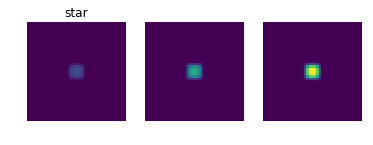

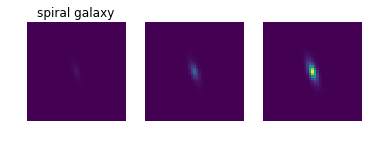

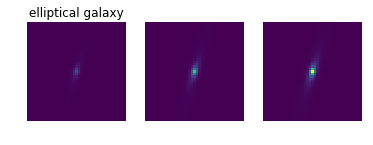

In [84]:
with np.load('data/galaxy_cubes.npz') as data:
    images = data['images']
    galaxy_labels = data['labels']

print([images.shape, galaxy_labels.shape])

show_images(images,galaxy_labels) 

## Add white noise to observations

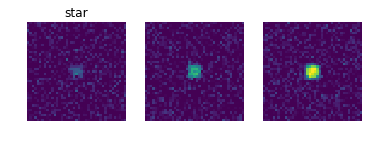

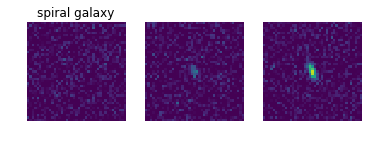

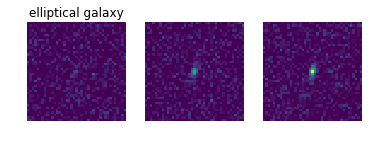

In [85]:
images= images+np.random.randn(10000,41,41,3)*20
images= np.clip(images, 0, 255)

show_images(images,galaxy_labels) 

# 3. Model

## Create training and testing (validation) dataset

**HINT:** to test various architectures fast keep the train/test sizes rather small

In [86]:
num_train_examples =   300  # 2000
num_test_examples  =    30  #  500

In [87]:
images_train=images[0:num_train_examples,:,:,:]
images_test=images[2500:2500+num_test_examples,:,:,:]

Train_data=images_train.reshape(num_train_examples, images.shape[1],images.shape[2],images.shape[3],1)
Test_data=images_test.reshape(num_test_examples, images.shape[1],images.shape[2],images.shape[3],1)

train_labels=galaxy_labels[0:num_train_examples]
test_labels=galaxy_labels[2500:2500+num_test_examples]

train_labels_cat=ult.to_categorical(train_labels,num_classes=3)
test_labels_cat=ult.to_categorical(test_labels,num_classes=3)

## Define network layers and characteristics

In [88]:
inputs = Input((images.shape[1], images.shape[2], images.shape[3], 1),name='main_input')

conv00  = Conv3D(16, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv00')(inputs)
#bn00 = BatchNormalization()(conv00)
act00 = Activation('relu')(conv00)
pool00  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act00)


conv10  = Conv3D(16, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv10')(pool00)
#bn10 = BatchNormalization()(conv10)
act10 = Activation('relu')(conv10)
#add00 = Add()([pool00,act10])
pool10  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act10)


conv20  = Conv3D(16, (3, 3, 2), strides=(1, 1, 1), padding='same', name='conv20')(pool10)
#bn20 = BatchNormalization()(conv20)
act20 = Activation('relu')(conv20)
#add20 = Add()([pool10,act20])
pool20  = MaxPooling3D(pool_size=(3, 3, 1), strides=(2, 2, 1), padding='same')(act20)

fl0 = Flatten(name='fl0')(pool00)
#Do0 = Dropout(rate=0.5)(fl0)
fc0 = Dense(32,activation='linear')(fl0)
#Do1 = Dropout(rate=0.5)(fc0)
fc1 = Dense(8,activation='linear')(fc0)
#Do2 = Dropout(rate=0.5)(fc1)

Dn0 = Dense(3,activation='softmax', name='Dn0' )(fc1)

model_1 = Model(inputs=[inputs], outputs=[Dn0])

## Select optimizer and compile the model

In [89]:
optzr =  Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, decay=0.0)
model_1.compile(loss='categorical_crossentropy', optimizer=optzr, metrics =['categorical_accuracy'])
model_1.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 41, 41, 3, 1)      0         
_________________________________________________________________
conv00 (Conv3D)              (None, 41, 41, 3, 16)     304       
_________________________________________________________________
activation_157 (Activation)  (None, 41, 41, 3, 16)     0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 21, 21, 3, 16)     0         
_________________________________________________________________
fl0 (Flatten)                (None, 21168)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                677408    
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 264

## Train the network

**HINT:** to test training fast keep the batch_size larger, and the epochs smaller 

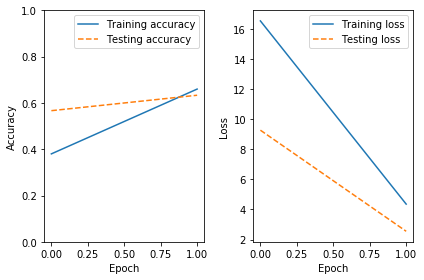

'00:00:13'

In [90]:
start_time = time.time() 
#es = EarlyStopping(monitor='categorical_accuracy')
                                                    # batchsze =20, epochs =50
history=model_1.fit(Train_data,train_labels_cat, 
                    batch_size=50, 
                    epochs=2,
                    validation_data=[Test_data,test_labels_cat],
                    callbacks=[plot_losses],shuffle=True)
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

## Check performance

In [91]:
ls,acc=model_1.evaluate(Test_data,test_labels_cat)
print("Loss value: %.2f" % (ls))  
print("Accuracy: %.1f" % (acc*100))   

30/30 [==============================] - 0s 2ms/step
Loss value: 2.55
Accuracy: 63.3


## Predict label for particular example

In [92]:
# select object
obj = 3        # mush be < len(Test_data)

preds=model_1.predict(Test_data[obj:obj+1,:,:,:,:])
print(preds)
print(test_labels[obj])

[[6.9322169e-08 9.9999976e-01 1.2666020e-07]]
0.0


## Use intemediate layers as outputs

In [93]:
lr1=model_1.layers[1].output  
lr2=model_1.layers[4].output
lr3=model_1.layers[7].output

activation_model_lr1 = Model(inputs=[inputs], outputs=lr1)
activation_model_lr2 = Model(inputs=[inputs], outputs=lr2)
activation_model_lr3 = Model(inputs=[inputs], outputs=lr3)


## Print the activations for particular inputs

21


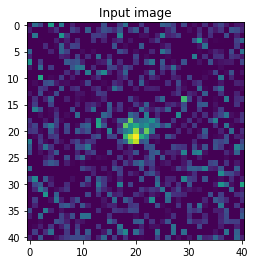

IndexError: too many indices for array

In [96]:
s = np.random.randint(0,len(Test_data)-1)
print(s)

plt.imshow(Test_data[s,:,:,0,0])
plt.title('Input image')
plt.show()

activations_lr1 = activation_model_lr1.predict(Test_data[s:s+1,:,:,:,:]) 
activations_lr2 = activation_model_lr2.predict(Test_data[s:s+1,:,:,:,:]) 
activations_lr3 = activation_model_lr2.predict(Test_data[s:s+1,:,:,:,:]) 

for i in range(16):
    img=activations_lr3[0,:,:,0,i]
    plt.imshow(img)
    plt.title('Number ' + str(i))
    plt.show()
plt.show()

# 4. Transfer Learning

<div style="text-align: center;">
<img src="images/ResNet-50-architecture.png"> 
Figure 4.1. The ResNet-50 architecture. <br>
(Credit: <a href="https://www.researchgate.net/figure/ResNet-50-architecture-26-shown-with-the-residual-units-the-size-of-the-filters-and_fig1_338603223"
 target="_blank" rel="noopener noreferrer">source</a>)
    </img>
    </div>


In [40]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [41]:
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(205, 205, 3))

FC_LAYERS = [256]
dropout = 0.5

finetune_model = build_finetune_model(base_model, dropout=dropout, fc_layers=FC_LAYERS, num_classes=3)

finetune_model.summary()


/home/grigoris/.local/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 205, 205, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 211, 211, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 103, 103, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 103, 103, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

## Resize the data

In [42]:
from PIL import Image
n_new_imgs = 100  # 3000
images2=np.empty([n_new_imgs,205,205,3])
for i in range(n_new_imgs):
    for c in range(3):
        tmp=images[i,:,:,c]
        img = Image.fromarray(tmp)
        img2 = img.resize((205,205),Image.BICUBIC)
        images2[i,:,:,c]=img2    

#show_figures(images2)

In [43]:
# if n_new_imgs = 3000
# Train_data=images2[0:num_train_examples,:,:,:]
# Test_data=images2[2500:2500+num_test_examples,:,:,:]

# for faster computation time
num_train_examples = int(n_new_imgs*0.7)
num_test_examples = n_new_imgs-num_train_examples
Train_data=images2[0:num_train_examples,:,:,:]
Test_data=images2[num_train_examples:num_train_examples+num_test_examples,:,:,:]


print(Train_data.shape)
print(Test_data.shape)

train_labels=galaxy_labels[0:num_train_examples]
test_labels=galaxy_labels[2500:2500+num_test_examples]

train_labels_cat=ult.to_categorical(train_labels,num_classes=3)
test_labels_cat=ult.to_categorical(test_labels,num_classes=3)

print(train_labels_cat.shape)
print(test_labels_cat.shape)

(70, 205, 205, 3)
(30, 205, 205, 3)
(70, 3)
(30, 3)


## Fine-tune pre-trained model

**HINT:** to test training fast keep the batch_size larger, and the epochs smaller 

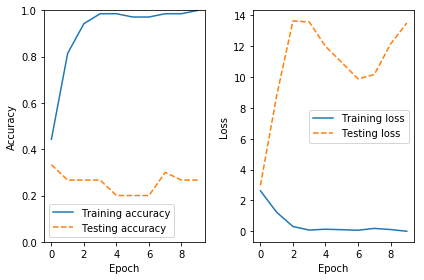

In [44]:
finetune_model.compile(optzr, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                                                                        # epochs =50
history = finetune_model.fit(Train_data,train_labels_cat, batch_size=20, epochs=10,validation_data=[Test_data,test_labels_cat],callbacks=[plot_losses],shuffle=True)


## Check the performance

In [47]:
ls,acc=finetune_model.evaluate(Test_data,test_labels_cat)
print("Loss value: %.2f" % (ls))  
print("Accuracy: %.1f" % (acc*100))  

30/30 [==============================] - 5s 181ms/step
Loss value: 13.51
Accuracy: 26.7


### Question: What do you notice?
<br>
<details>
<summary>Click for answer</summary>
If the training accuracy is very close to 1 and the training loss always systematically under the test loss then the model is overfitting!
    
Check <a href='https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/' target="_blank" rel="noopener noreferrer"> this site</a> for how to diagnosize the various cases.

</details>